In [9]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
#from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [10]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [11]:
IM_SHAPE=(225,225)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [12]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Test',
    #batch_size=16,
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
#from keras.applications import DenseNet121

from keras.applications import inception_resnet_v2 
vgg =  inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

2023-02-08 02:50:11.945128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 02:50:12.055717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 02:50:12.056913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 02:50:12.059374: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 2s 0us/step


In [14]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7ff30a423a90>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7ff30927c090>,conv2d,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff30857ac90>,batch_normalization,False
3,<keras.layers.core.Activation object at 0x7ff3087661d0>,activation,False
4,<keras.layers.convolutional.Conv2D object at 0x7ff306d9f350>,conv2d_1,False
...,...,...,...
776,<keras.layers.core.Lambda object at 0x7ff2e03d2690>,block8_10,False
777,<keras.layers.convolutional.Conv2D object at 0x7ff2e03d2750>,conv_7b,False
778,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff2e0385b10>,conv_7b_bn,False
779,<keras.layers.core.Activation object at 0x7ff2e0385210>,conv_7b_ac,False


In [15]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


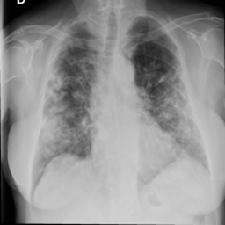

In [16]:
array_to_img(train_generator_NEW[0][0][0])

2023-02-08 02:50:21.471657: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-08 02:50:25.212248: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 5, 5, 1536)


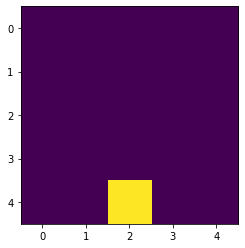

In [17]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [18]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
# model_TF.add(Dense(1024, activation='relu')) 
# model_TF.add(Dropout(0.25)) 
# model_TF.add(Dense(512, activation='relu')) 
# model_TF.add(Dropout(0.25))
# model_TF.add(Dense(256, activation='relu')) 
# model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 38400)             54336736  
_________________________________________________________________
dense (Dense)                (None, 2)                 76802     
Total params: 54,413,538
Trainable params: 76,802
Non-trainable params: 54,336,736
_________________________________________________________________


In [13]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [22]:
history_TF = model_TF.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 165s 344ms/step - loss: 0.6315 - accuracy: 0.6672 - f1_m: 0.6506 - precision_m: 0.6769 - recall_m: 0.6297 - val_loss: 0.6112 - val_accuracy: 0.6733 - val_f1_m: 0.6643 - val_precision_m: 0.6826 - val_recall_m: 0.6474
Epoch 2/15
452/452 [==============================] - 76s 168ms/step - loss: 0.6068 - accuracy: 0.6927 - f1_m: 0.6841 - precision_m: 0.7031 - recall_m: 0.6666 - val_loss: 0.5000 - val_accuracy: 0.7645 - val_f1_m: 0.7603 - val_precision_m: 0.7779 - val_recall_m: 0.7440
Epoch 3/15
452/452 [==============================] - 78s 173ms/step - loss: 0.5801 - accuracy: 0.7118 - f1_m: 0.7058 - precision_m: 0.7240 - recall_m: 0.6890 - val_loss: 0.5310 - val_accuracy: 0.7464 - val_f1_m: 0.7409 - val_precision_m: 0.7536 - val_recall_m: 0.7288
Epoch 4/15
452/452 [==============================] - 76s 169ms/step - loss: 0.5302 - accuracy: 0.7428 - f1_m: 0.7327 - precision_m: 0.7520 - recall_m: 0.7150 - val_loss: 0.4599 - val_accuracy: 0.7928 - 

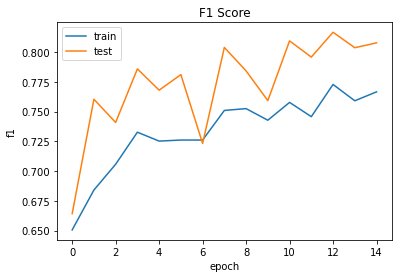

In [26]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 8s 119ms/step - loss: 0.5188 - accuracy: 0.7475 - f1_m: 0.7438 - precision_m: 0.7622 - recall_m: 0.7267


In [18]:
test_loss

[0.6941359639167786,
 0.5005000233650208,
 0.4995039403438568,
 0.4995039701461792,
 0.4995039701461792]

In [19]:
from keras.applications import inception_resnet_v2 
dense =  inception_resnet_v2.InceptionResNetV2(include_top=False,  
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True


In [20]:
model = Sequential() 

model.add(dense_model) 
# model.add(Dense(1024, activation='relu')) 
# model.add(Dropout(0.25)) 
# model.add(Dense(512, activation='relu')) 
# model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 38400)             54336736  
_________________________________________________________________
dropout (Dropout)            (None, 38400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 76802     
Total params: 54,413,538
Trainable params: 54,352,994
Non-trainable params: 60,544
_________________________________________________________________


In [22]:
history = model.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
452/452 [==============================] - 317s 667ms/step - loss: 0.1844 - accuracy: 0.9240 - f1_m: 0.8902 - precision_m: 0.9418 - recall_m: 0.8478 - val_loss: 1.0400 - val_accuracy: 0.4314 - val_f1_m: 0.3917 - val_precision_m: 0.4269 - val_recall_m: 0.3634
Epoch 2/15
452/452 [==============================] - 296s 655ms/step - loss: 0.0468 - accuracy: 0.9823 - f1_m: 0.9742 - precision_m: 0.9896 - recall_m: 0.9598 - val_loss: 0.1584 - val_accuracy: 0.9579 - val_f1_m: 0.9535 - val_precision_m: 0.9643 - val_recall_m: 0.9433
Epoch 3/15
452/452 [==============================] - 296s 655ms/step - loss: 0.0146 - accuracy: 0.9956 - f1_m: 0.9914 - precision_m: 0.9975 - recall_m: 0.9855 - val_loss: 0.1519 - val_accuracy: 0.9597 - val_f1_m: 0.9548 - val_precision_m: 0.9712 - val_recall_m: 0.9395
Epoch 4/15
452/452 [==============================] - 296s 655ms/step - loss: 0.0113 - accuracy: 0.9961 - f1_m: 0.9922 - precision_m: 0.9984 - recall_m: 0.9862 - val_loss: 0.4276 - val_accur

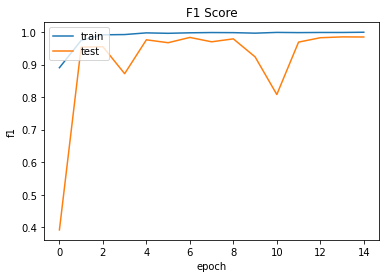

In [23]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 14s 218ms/step - loss: 0.0944 - accuracy: 0.9810 - f1_m: 0.9801 - precision_m: 0.9825 - recall_m: 0.9777


In [25]:
test_loss

[0.09436170756816864,
 0.9810000061988831,
 0.9800558686256409,
 0.9825258255004883,
 0.9776785969734192]